# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata

,timestamp,sqrtPriceX96,price,datetime
0,1620609472,1267554519342589161168659854845874,0.000256,2021-05-10 01:17:52
1,1620609830,1267498129839936824485169221023868,0.000256,2021-05-10 01:23:50
2,1620609889,1267496927736336268048970777338285,0.000256,2021-05-10 01:24:49
3,1620609889,1267496466129159558106023913391909,0.000256,2021-05-10 01:24:49
4,1620609894,1267269382521328460205280017540103,0.000256,2021-05-10 01:24:54
...,...,...,...,...
153322,1636505287,1151304179731807924804200863381341,0.000211,2021-11-10 00:48:07
153323,1636505306,1153213095406308275655367738380110,0.000212,2021-11-10 00:48:26
153324,1636505306,1153226560737155904671591020768514,0.000212,2021-11-10 00:48:26
153325,1636505306,1153227466349991390439811165863993,0.000212,2021-11-10 00:48:26


In [2]:
pricedata['datetime'].tolist()[0]

'2021-05-10 01:17:52'

# 指标计算

In [3]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#之后要扩展回测区间时，需要更新此处的基本行情数据
df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211116_60min_v16_E')['60min']
df_eth.columns= ['open','high','low','close','volume']
df_eth = df_eth.loc['2018-03-22':'2021-11-09']
df_eth.reset_index(inplace=True)
df_eth.columns = ['datetime','open','high','low','close','volume']
def cal_indicator(dataCoin):    
    dataCoin['pctChange'] = dataCoin['close'].pct_change()
    dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)
    dataCoin['pctStdVma'] = ta.SUM(dataCoin['pctStd']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['closeVma'] = ta.SUM(dataCoin['close']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['pctStdVSma'] = ta.EMA(dataCoin.pctStdVma, 24*3)
    dataCoin['pctStdVLma'] = ta.MA(dataCoin.pctStdVma, 24*10)
    dataCoin['SmaLowerLma'] = dataCoin['pctStdVSma']<dataCoin['pctStdVLma']
    dataCoin['CloseLowerMA'] = dataCoin['close'] < dataCoin['closeVma']
    #根据volResearch notebook里的BelowMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolLowerBelowmaQuantile50'] = dataCoin['pctStd'] < 0.035857 
    #根据volResearch notebook里的OverMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolHigherOvermaQuantile50Twosigma'] = dataCoin['pctStd'] > (0.038511 + 2*0.018451)
    #当波动率高于Belowma的vol stat中的Quantile50的1.05倍时撤销池子
    dataCoin['revoke_pos'] = dataCoin['pctStd'] > 0.035857 *1.05
    
cal_indicator(df_eth)

df_eth_test_period = df_eth[df_eth['datetime']>parse('2021-05-10 00:00:00+00:00')]
df_signal_tmp = df_eth_test_period[['datetime',
                               'SmaLowerLma',
                               'VolLowerBelowmaQuantile50',
                               'CloseLowerMA',
                               'VolHigherOvermaQuantile50Twosigma',
                               'revoke_pos',
                               'pctStd',
                               'close',
                                'closeVma']]
df_signal_tmp['timestamp'] = [0]*len(df_signal_tmp)
df_signal_tmp['sqrtPriceX96'] = [0]*len(df_signal_tmp)
df_signal_tmp['price'] = [0]*len(df_signal_tmp)

df_signal_tmp = df_signal_tmp[['timestamp','sqrtPriceX96','price','datetime',
                 'SmaLowerLma',
                 'VolLowerBelowmaQuantile50',
                 'CloseLowerMA',
                 'VolHigherOvermaQuantile50Twosigma',
                 'revoke_pos',
                 'pctStd',
                  'close',
                  'closeVma']]
df_signal_tmp['datetime_2'] = df_signal_tmp['datetime']
df_signal_tmp = df_signal_tmp.set_index('datetime_2')
# df_signal_tmp = df_signal_tmp.resample('D').first()
df_signal_tmp['datetime'] = [str(tmp)[:-6] for tmp in df_signal_tmp['datetime'].tolist()]
df_signal_tmp['ind'] = [i for i in range(len(pricedata),len(pricedata)+len(df_signal_tmp))]
df_signal_tmp.set_index('ind',inplace=True)
pricedata_tmp = pricedata.append(df_signal_tmp)
pricedata_tmp = pricedata_tmp.sort_values(by='datetime')
pricedata_tmp_beforefill = pricedata_tmp.copy(deep = True)
pricedata_tmp = pricedata_tmp.fillna(method = 'ffill')
pricedata_res = pricedata_tmp.loc[pricedata.index]
pricedata_res.set_index('datetime',inplace=True)
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos,pctStd,close,closeVma
datetime,,,,,,,,,,,
2021-05-10 01:17:52,1620609472,1267554519342589161168659854845874,0.000256,False,False,False,False,True,0.053879,3928.23,2463.762290
2021-05-10 01:23:50,1620609830,1267498129839936824485169221023868,0.000256,False,False,False,False,True,0.053879,3928.23,2463.762290
2021-05-10 01:24:49,1620609889,1267496927736336268048970777338285,0.000256,False,False,False,False,True,0.053879,3928.23,2463.762290
2021-05-10 01:24:49,1620609889,1267496466129159558106023913391909,0.000256,False,False,False,False,True,0.053879,3928.23,2463.762290
2021-05-10 01:24:54,1620609894,1267269382521328460205280017540103,0.000256,False,False,False,False,True,0.053879,3928.23,2463.762290
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 00:48:07,1636505287,1151304179731807924804200863381341,0.000211,True,True,False,False,False,0.023363,4732.33,3678.451309
2021-11-10 00:48:26,1636505306,1153213095406308275655367738380110,0.000212,True,True,False,False,False,0.023363,4732.33,3678.451309
2021-11-10 00:48:26,1636505306,1153226560737155904671591020768514,0.000212,True,True,False,False,False,0.023363,4732.33,3678.451309


# 回测

In [4]:
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 0.0002559611947100053


# 建池撤池详细信息

In [5]:
import Strategy_usdceth_vol_v2
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_usdceth_vol_v2)
strategy = Strategy_usdceth_vol_v2.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000000.0 amount1:  140631495516086534144
price:  0.0002559611947100053
$$$$$$$【Upper Price】: 0.00033005978975935465
$$$$$$$【Lower Price】: 0.00019849777291908478
######【L】:60666448444272064【USDC】:449725000000【ETH】:117247551451873394688
将要投入池子的数量 amount_t0: 449725000000 amount_t1: 117247551451873165312
【RealWorldTime】:2021-05-10 09:17:52, Timestamp: 1620609472, Blocknumber: 12403600
Mint position： Position(L=60665339031571984, tick=[191040, 196140], range=[3035.1064, 5054.2070])
【Mint amount】: token0=449708.399096, token1=117.24755145187316
Wallet amount: token0=16.600904, token1=23.38394406421337
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: False, VolHigherQuantile50TwoSigma: True
Price(0.00023814266965707472) out of range(0.00019849777291908478, 0.00033005978975935465)
【RealWorldT

******************************************【撤销池子】【原因:超边撤池】******************************************
Price(0.000277432219764514) out of range(0.00027786275245102074, 0.00046202695530153144)
【RealWorldTime】:2021-09-02 00:31:37,Timestamp: 1630513897, Blocknumber: 13140848
Decreased position： Position(L=0, tick=[194400, 199500], range=[2168.9936, 3611.9138])
【Decreased amount】: token0=1088041.69666, token1=3.192292366057026
Wallet amount: token0=1091277.683317, token1=43.08064536412536
撤池后经转换 Wallet amount: token0=1246121.902431, token1=2.1899148389064997
**********************【Price Over MA】【创建Long Vol池子】【第8次建池】***********************************
转换后钱包中余额 amount0:  560412172571.0 amount1:  192209139043566351168
price:  0.00027679293620883804
$$$$$$$【Upper Price】: 0.0003569221437470984
$$$$$$$【Lower Price】: 0.0002146527775799641
######【L】:78670523595172320【USDC】:560412172571【ETH】:158220682731461410816
将要投入池子的数量 amount_t0: 560412172571 amount_t1: 158220682731461148672
【RealWorldTime】:2021-0

# 获取原始绩效

In [6]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x1cf4b5235c0>,
 2: <univ3api.simulation.PositionReport at 0x1cf4b523128>,
 3: <univ3api.simulation.PositionReport at 0x1cf4b5169b0>,
 4: <univ3api.simulation.PositionReport at 0x1cf4b516f98>,
 5: <univ3api.simulation.PositionReport at 0x1cf4b516128>,
 6: <univ3api.simulation.PositionReport at 0x1cf4b516da0>,
 7: <univ3api.simulation.PositionReport at 0x1cf4b4cada0>,
 8: <univ3api.simulation.PositionReport at 0x1cf4bc9b908>,
 9: <univ3api.simulation.PositionReport at 0x1cf4bc9bcf8>,
 10: <univ3api.simulation.PositionReport at 0x1cf4bc9b4e0>,
 11: <univ3api.simulation.PositionReport at 0x1cf4bcd0400>}

In [7]:
positions[1].get_balance(plain=True, draw_plot=True)

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-05-10 09:17:52,449708.399096,0.000000,0.000000,0.000000,117.248,0.000000,0.000000,0.000000
1,2021-05-10 09:17:52,449708.399096,0.000000,0.000000,0.000000,117.248,0.000000,0.000000,0.000000
2,2021-05-10 09:23:50,449877.094986,0.084347,0.084347,0.084347,117.204,0.000000,0.000000,0.000000
3,2021-05-10 09:24:49,449880.691385,0.001798,0.086145,0.086145,117.203,0.000000,0.000000,0.000000
4,2021-05-10 09:24:49,449882.072402,0.000690,0.086835,0.086835,117.203,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2049,2021-05-13 06:57:36,587787.552991,8.823038,1518.373289,1518.373289,83.1464,0.000000,0.360122,0.360122
2050,2021-05-13 06:57:43,586184.856427,0.000000,1518.373289,1518.373289,83.5285,0.000191,0.360313,0.360313
2051,2021-05-13 06:57:51,584947.195152,0.000000,1518.373289,1518.373289,83.8237,0.000148,0.360461,0.360461
2052,2021-05-13 06:59:25,589239.050287,2.145927,1520.519216,1520.519216,82.8007,0.000000,0.360461,0.360461


In [8]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

<AxesSubplot:title={'center':'Total Balance'}>

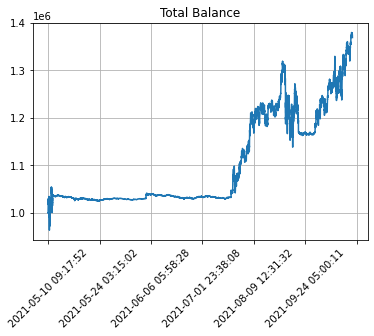

In [9]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True,title='Total Balance')
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [10]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620609472,549425.062949
1620609830,549305.247193
1620609889,549301.311704
1620609894,548818.966510
1620610623,549850.059551
...,...
1636505114,503688.673053
1636505262,503899.744855
1636505287,503909.105368


In [11]:
usdc_balance
usdc_balance_df = pd.DataFrame(usdc_balance)
usdc_balance_df.columns = ['usdc_balance']
usdc_balance_df

,usdc_balance
timestamp,
1620609472,449725.000000
1620609830,449893.780237
1620609889,449898.760141
1620609894,450578.601202
1620610623,449127.923524
...,...
1636505084,868798.366142
1636505114,867034.745834
1636505262,866772.024623


In [12]:
tb_Timing

2021-05-10 09:17:52    9.991501e+05
2021-05-10 09:23:50    9.991990e+05
2021-05-10 09:24:49    9.992001e+05
2021-05-10 09:24:54    9.993976e+05
2021-05-10 09:37:03    9.989780e+05
                           ...     
2021-11-10 08:45:14    1.370723e+06
2021-11-10 08:47:42    1.370672e+06
2021-11-10 08:48:07    1.370669e+06
2021-11-10 08:48:26    1.368993e+06
2021-11-10 08:48:53             NaN
Length: 118264, dtype: float64

# 计算绩效指标

In [13]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    1.031153e+06
2021-05-11    1.013338e+06
2021-05-12    1.037895e+06
2021-05-13    1.035107e+06
2021-05-14    1.037181e+06
                  ...     
2021-11-06    1.327475e+06
2021-11-07    1.354459e+06
2021-11-08    1.372810e+06
2021-11-09    1.376734e+06
2021-11-10    1.368993e+06
Freq: D, Length: 185, dtype: float64

In [14]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb_strategy_noresample = pd.DataFrame(tb_Timing,columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,1.031153e+06,NaN,NaN
2021-05-11,1.013338e+06,-0.017277,-0.017277
2021-05-12,1.037895e+06,0.024234,0.024234
2021-05-13,1.035107e+06,-0.002686,-0.002686
2021-05-14,1.037181e+06,0.002003,0.002003
...,...,...,...
2021-11-05,1.337787e+06,-0.002394,-0.002394
2021-11-06,1.327475e+06,-0.007708,-0.007708
2021-11-07,1.354459e+06,0.020327,0.020327
2021-11-08,1.372810e+06,0.013548,0.013548


<AxesSubplot:>

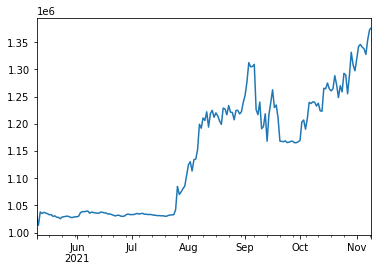

In [15]:
df_tb['close'].plot()

In [16]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


# 输出绩效

【SWAP_USDC_WETH_3000】

USDC手续费 11975.355579 ETH手续费(USDC计价) 15412.933450180983
***************************资金曲线绩效***************************
最大回撤 0.1121939491106374
最长回撤持续期 55 日 起始日期 2021-09-03 00:00:00 结束日期 2021-10-28 00:00:00
年化收益 0.7797855277867178
夏普比率 3.041393978899603
卡尔玛比率 6.950334968757993


<AxesSubplot:title={'center':'Total Balance'}>

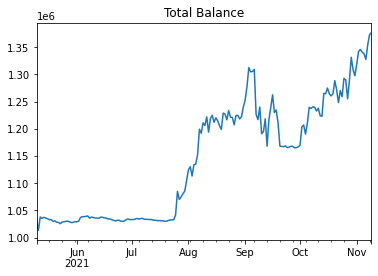

In [17]:
print('【SWAP_USDC_WETH_3000】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('USDC手续费',cumfee0,'ETH手续费(USDC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')

In [34]:
annualReturnNoneStrategy50 = 0.22855581332998387
annualReturnNoneStrategy100 = 0.29521239617921324
annualRetrunStrategy = 0.7797855277867178
print('相对Case_usdceth_none_3000_50per年化',annualRetrunStrategy - annualReturnNoneStrategy50)
print('相对Case_usdceth_none_3000_100per年化',annualRetrunStrategy - annualReturnNoneStrategy100)

相对Case_usdceth_none_3000_50per年化 0.551229714456734
相对Case_usdceth_none_3000_100per年化 0.4845731316075046


# 画波动率以及价格走势图代码

In [19]:
#获取开仓时间
openTimes = []
closeTimes = []
for i in range(1,len(positions)+1):
    open_tick = positions[i].get_balance(plain=True, draw_plot=False)['datetime'].tolist()[0]
    close_tick = positions[i].get_balance(plain=True, draw_plot=False)['datetime'].tolist()[-1]
    openTimes.append(open_tick)
    closeTimes.append(close_tick)
#     positions[5].get_balance(plain=True, draw_plot=True)
print('open',openTimes,'len =',len(openTimes))
print()
print('close',closeTimes,'len =',len(closeTimes))

open [Timestamp('2021-05-10 09:17:52'), Timestamp('2021-06-03 16:50:54'), Timestamp('2021-06-04 06:52:40'), Timestamp('2021-07-24 23:59:37'), Timestamp('2021-07-25 06:58:38'), Timestamp('2021-07-26 06:56:05'), Timestamp('2021-08-05 22:41:34'), Timestamp('2021-09-02 00:31:41'), Timestamp('2021-10-01 23:59:35'), Timestamp('2021-10-02 11:53:35'), Timestamp('2021-10-21 09:18:22')] len = 11

close [Timestamp('2021-05-13 06:59:25'), Timestamp('2021-06-03 18:48:59'), Timestamp('2021-06-04 07:57:40'), Timestamp('2021-07-25 01:54:30'), Timestamp('2021-07-25 07:56:26'), Timestamp('2021-08-05 22:40:10'), Timestamp('2021-09-02 00:31:37'), Timestamp('2021-09-20 10:59:57'), Timestamp('2021-10-02 10:58:16'), Timestamp('2021-10-21 09:17:51'), Timestamp('2021-11-10 08:48:26')] len = 11


In [20]:
indWithOpen = pricedata_res.index.tolist()
# .append(str(openTimes[0]))
# indWithOpen.sort()
# indWithOpen
for open_tick in openTimes:
    indWithOpen.append(str(open_tick))
# indWithOpen.append(str(openTimes[0]))
indWithOpen.sort()
len(indWithOpen)

153338

In [21]:
indWithClose = pricedata_res.index.tolist()
# .append(str(openTimes[0]))
# indWithOpen.sort()
# indWithOpen
for close_tick in closeTimes:
    indWithClose.append(str(close_tick))
# indWithOpen.append(str(openTimes[0]))
indWithClose.sort()
len(indWithClose)

153338

# 【波动率以及价格走势图】

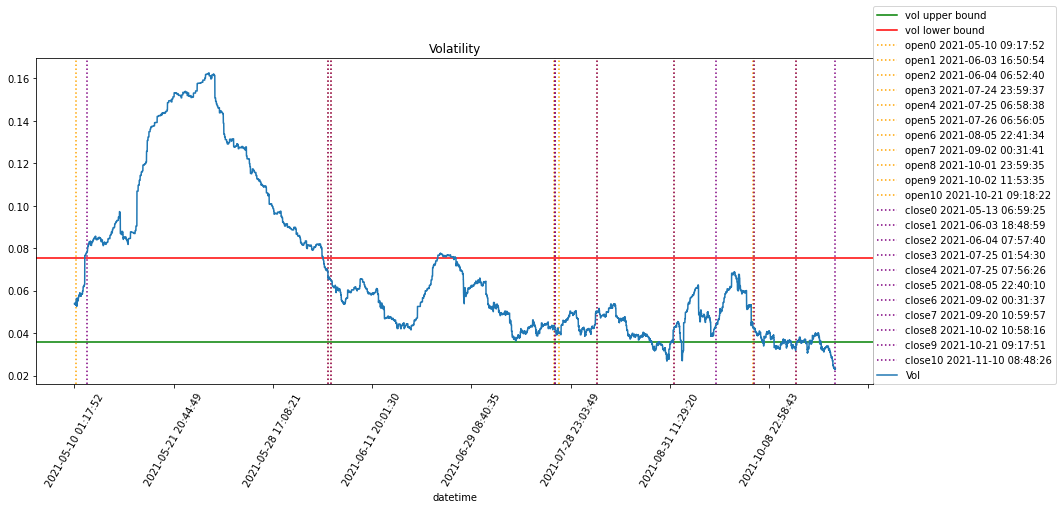

In [22]:
from matplotlib import pyplot as plt

#画波动率阈值线
vol_low = 0.035857
vol_up = 0.038511 + 2*0.018451
plt.axhline(y=vol_low,ls="-",c="green",label = 'vol upper bound')
plt.axhline(y=vol_up,ls="-",c="red",label = 'vol lower bound')

for open_tick in openTimes:
    xv = indWithOpen.index(str(open_tick))
    plt.axvline(x=xv,ls=":",c="orange",label='open'+str(openTimes.index(open_tick))+' '+str(open_tick))

for close_tick in closeTimes:
    xv = indWithClose.index(str(close_tick))
    plt.axvline(x=xv,ls=":",c="purple",label='close'+str(closeTimes.index(close_tick))+' '+str(close_tick))

pricedata_res['pctStd'].plot(rot = 60,figsize=(15,6),label='Vol',title='Volatility')
num1 = 1
num2 = 0
num3 = 3
num4 = 0
plt.legend(bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4)

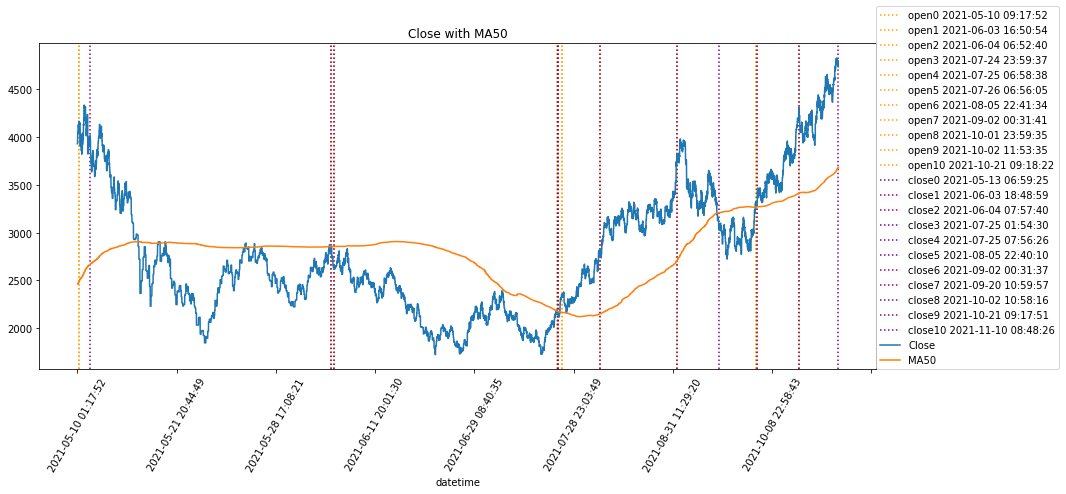

In [23]:
for open_tick in openTimes:
    xv = indWithOpen.index(str(open_tick))
    plt.axvline(x=xv,ls=":",c="orange")

    
for open_tick in openTimes:
    xv = indWithOpen.index(str(open_tick))
    plt.axvline(x=xv,ls=":",c="orange",label='open'+str(openTimes.index(open_tick))+' '+str(open_tick))

for close_tick in closeTimes:
    xv = indWithClose.index(str(close_tick))
    plt.axvline(x=xv,ls=":",c="purple",label='close'+str(closeTimes.index(close_tick))+' '+str(close_tick))
    
pricedata_res['close'].plot(rot = 60,figsize=(15,6),label='Close',title = 'Close with MA50')
pricedata_res['closeVma'].plot(rot = 60,figsize=(15,6),label='MA50')

num1 = 1
num2 = 0
num3 = 3
num4 = 0
plt.legend(bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4)

# 画相对收益图代码

In [24]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata.head(30)
pricedata['SmaLowerLma'] = [np.nan]*len(pricedata)
pricedata['VolLowerBelowmaQuantile50'] = [np.nan]*len(pricedata)
pricedata['CloseLowerMA'] = [np.nan]*len(pricedata)
pricedata['VolHigherOvermaQuantile50Twosigma'] = [np.nan]*len(pricedata)
pricedata['revoke_pos'] = [np.nan]*len(pricedata)
pricedata_res = pricedata[['timestamp','sqrtPriceX96','price',
                           'SmaLowerLma',
                           'VolLowerBelowmaQuantile50',
                          'CloseLowerMA',
                           'VolHigherOvermaQuantile50Twosigma',
                           'revoke_pos']]
pricedata_res
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)
import Strategy_none_3000_50per
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_none_3000_50per)
strategy = Strategy_none_3000_50per.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()
positions = report.positions
positions
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
# tb_Timing.plot(rot = 45,grid=True)
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

# df_tb_noStrategy_3000_50per = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb_noStrategy_3000_50per = pd.DataFrame(tb_Timing,columns=['close'])
df_tb_noStrategy_3000_50per['return'] = df_tb_noStrategy_3000_50per['close'].pct_change()
df_tb_noStrategy_3000_50per['return_2'] = df_tb_noStrategy_3000_50per['close']/df_tb_noStrategy_3000_50per['close'].shift(1) - 1
df_tb_noStrategy_3000_50per = df_tb_noStrategy_3000_50per.iloc[:-1,:]


init_price = 0.0002559611947100053
**********************【Price Below MA】【创建Short Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  349675000000.0 amount1:  166169275899699363840
price:  0.0002559611947100053
$$$$$$$【Upper Price】: 0.00038394179206500793
$$$$$$$【Lower Price】: 0.00012798059735500265
######【L】:30690405793635532【USDC】:349675000000【ETH】:144215143323547123712
将要投入池子的数量 amount_t0: 349675000000 amount_t1: 144215143323547058176
【RealWorldTime】:2021-05-10 09:17:52, Timestamp: 1620609472, Blocknumber: 12403600
Mint position： Position(L=30690174960131528, tick=[186660, 197640], range=[2612.3599, 7831.8525])
【Mint amount】: token0=349668.132233, token1=144.21514332354707
Wallet amount: token0=6.867767, token1=21.954132576152304


In [25]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_USDC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(6, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata.head(30)
pricedata['SmaLowerLma'] = [np.nan]*len(pricedata)
pricedata['VolLowerBelowmaQuantile50'] = [np.nan]*len(pricedata)
pricedata['CloseLowerMA'] = [np.nan]*len(pricedata)
pricedata['VolHigherOvermaQuantile50Twosigma'] = [np.nan]*len(pricedata)
pricedata['revoke_pos'] = [np.nan]*len(pricedata)
pricedata_res = pricedata[['timestamp','sqrtPriceX96','price',
                           'SmaLowerLma',
                           'VolLowerBelowmaQuantile50',
                          'CloseLowerMA',
                           'VolHigherOvermaQuantile50Twosigma',
                           'revoke_pos']]
pricedata_res
init_price = pricedata_res["price"][0]

decimal0 = 6 #USDC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 1000000*1e6 #初始持有USDC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)
import Strategy_none_3000_100per
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_none_3000_100per)
strategy = Strategy_none_3000_100per.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()
positions = report.positions
positions
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
usdc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+usdc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+usdc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
# tb_Timing.plot(rot = 45,grid=True)
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

# df_tb_noStrategy_3000_100per = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb_noStrategy_3000_100per = pd.DataFrame(tb_Timing,columns=['close'])
df_tb_noStrategy_3000_100per['return'] = df_tb_noStrategy_3000_100per['close'].pct_change()
df_tb_noStrategy_3000_100per['return_2'] = df_tb_noStrategy_3000_100per['close']/df_tb_noStrategy_3000_100per['close'].shift(1) - 1
df_tb_noStrategy_3000_100per = df_tb_noStrategy_3000_100per.iloc[:-1,:]


init_price = 0.0002559611947100053
**********************【Price Below MA】【创建Short Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  149575000000.0 amount1:  217215730718302502912
price:  0.0002559611947100053
$$$$$$$【Upper Price】: 0.0005119223894200106
$$$$$$$【Lower Price】: 2.5596119471000553e-07
######【L】:8196810249066651【USDC】:149575000000【ETH】:126998805173135507456
将要投入池子的数量 amount_t0: 149575000000 amount_t1: 126998805173135491072
【RealWorldTime】:2021-05-10 09:17:52, Timestamp: 1620609472, Blocknumber: 12403600
Mint position： Position(L=8196791550993594, tick=[124500, 200520], range=[1958.6753, 3920162.1450])
【Mint amount】: token0=149573.526975, token1=126.9988051731355
Wallet amount: token0=1.473025, token1=90.21692554516702


In [29]:
df_tb_noStrategy_3000_100per
df_tb_noStrategy_3000_50per
df_tb_strategy_noresample
df_close = pd.DataFrame({
                        'strategy':df_tb_strategy_noresample['close'],
                        'nostrategy_3000_100per':df_tb_noStrategy_3000_100per['close'],
                        'nostrategy_3000_50per':df_tb_noStrategy_3000_50per['close'],
                        })
df_close['strategy_excess_50'] = df_close['strategy'] - df_close['nostrategy_3000_50per']
df_close['strategy_excess_100'] = df_close['strategy'] - df_close['nostrategy_3000_100per']

# 【相对收益图】

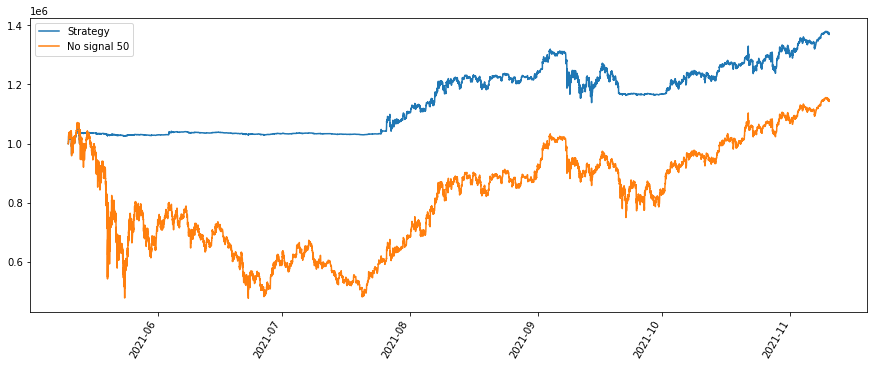

In [30]:
df_close['strategy'].plot(rot = 60,figsize=(15,6),label='Strategy')
df_close['nostrategy_3000_50per'].plot(rot = 60,figsize=(15,6),label='No signal 50')
plt.legend()

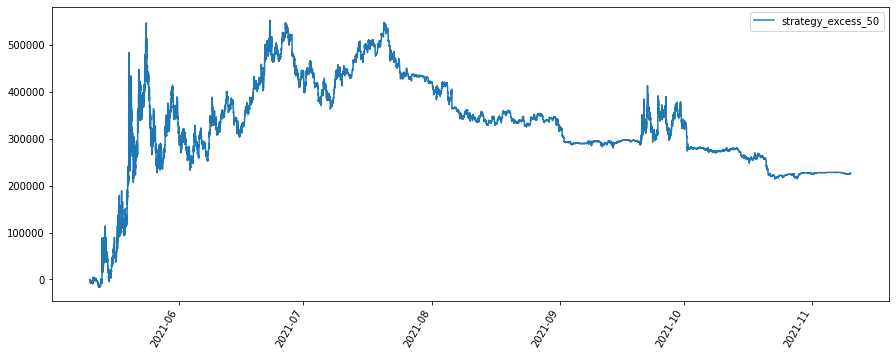

In [32]:
df_close['strategy_excess_50'].plot(rot = 60,figsize=(15,6),label='strategy_excess_50')
plt.legend()

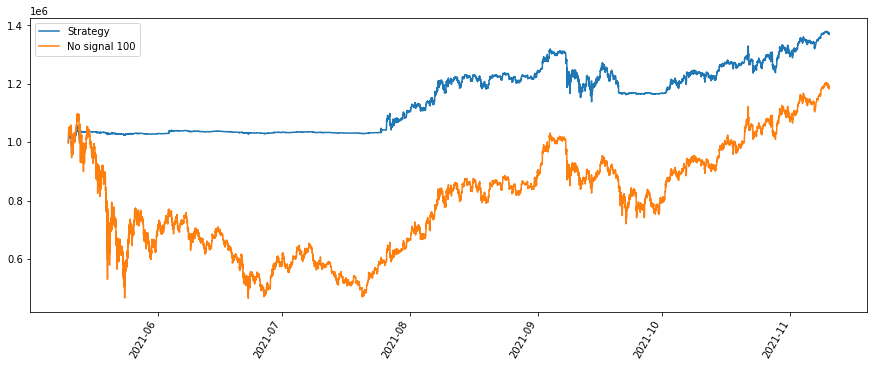

In [31]:
df_close['strategy'].plot(rot = 60,figsize=(15,6),label='Strategy')
df_close['nostrategy_3000_100per'].plot(rot = 60,figsize=(15,6),label='No signal 100')
plt.legend()

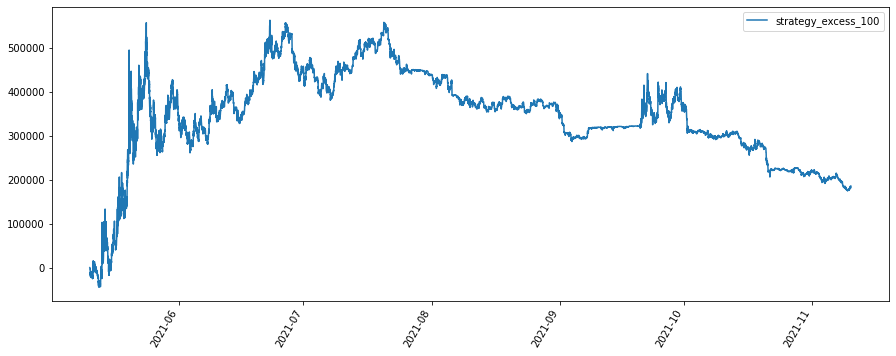

In [33]:
df_close['strategy_excess_100'].plot(rot = 60,figsize=(15,6),label='strategy_excess_100')
plt.legend()